In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("./")

In [3]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from utils import (
    load_betelgeuse_data_random_split, 
    load_betelgeuse_data_sequential_split, 
)
from IPython.display import display, Code


torch.manual_seed(707)

# Gaussian Processes Regression

### Gaussian Process
Based on [4] _Quadrianto N., Kersting K., Xu Z. (2011) Gaussian Process. In: Sammut C., Webb G.I. (eds) Encyclopedia of Machine Learning. Springer, Boston, MA_ ([link](https://link.springer.com/referenceworkentry/10.1007/978-0-387-30164-8_324))

*Gaussian processes* generalize multivariate Gaussian distributions over finite dimensional vectors to infinite dimensionality. Specifically, a Gaussian process is a stochastic process that has Gaussian distributed finite dimensional marginal distributions, hence the name. In doing so, it defines a distribution over functions, i.e., each draw from a Gaussian process is a function. Gaussian processes provide a principled, practical, and probabilistic approach to inference and learning in kernel machines.

Formally, a Gaussian process is a stochastic process (i.e., a collection of random variables) in which all the finite-dimensional distributions are multivariate Gaussian distributions for any finite choice of variables. In general, Gaussian processes are used to define a probability distribution over functions $f: X \rightarrow \mathbb{R}$ such that the set of values of $f$ evaluated at an arbitrary set of points $\{x_i\}^N_{i=1} \in X$ will have an $N$-variate Gaussian distribution.

The *Finite Representation* is "good enough" what is guaranteed by the [Kolmogorov extension theorem](https://en.wikipedia.org/wiki/Kolmogorov_extension_theorem).

For a more detailed description of *Model Representations* (e.g. *Finite Representation*), *Exchangeability* (a crucial concept in Probabilistic Modelling; we will refer to it when talking about Conformal Prediction) and the general relation between stochastic processes and Bayesian Non-Parametric models please refer to *Theory* section of [5] _Orbanz P., Teh Y.W. (2011) Bayesian Nonparametric Models. In: Sammut C., Webb G.I. (eds) Encyclopedia of Machine Learning. Springer, Boston, MA ([link](https://link.springer.com/referenceworkentry/10.1007%2F978-0-387-30164-8_66)).

A Gaussian distribution is completely specified by its mean and covariance matrix. Similarly, a Gaussian process is characterized by its mean function 

$$ m(x) := \mathbb{E}[f(x)] $$ 

and covariance function

$$ C(x, x') := \mathbb{E}[(f(x) - m(x))(f(x') - m(x'))]. $$

The mean function can be arbitrarily chosen (for convenience, it is often taken to be a zero function since we can always center our observed outputs to have a zero mean), but the covariance function mustbe a [positive definite function](https://en.wikipedia.org/wiki/Positive-definite_function) to ensure the existence of all finite-dimensional distributions. That is, the positive definiteness of $C(.,.)$ ensures the [positive (semi-)definiteness](https://en.wikipedia.org/wiki/Definiteness_of_a_matrix#Definitions_for_real_matrices) of all covariance matrices, $\Sigma$, appearing in the exponent of the finite-dimensional multivariate Gaussian distribution.

There are generally two types of covariance functions: *stationary* and *non-stationary*. A stationary covariance function is a function that is translation invariant, i.e., $C(x,x′) = D(x−x′)$ for some function $D$. The typical examples include squared exponential, Matern class, $\gamma$-exponenetial, exponential, rational quadratic, while examples of non-stationary covariance functions are dot product and polynomial.

The attractiveness of Gaussian processes is that they admit the marginalization property, i.e., if the Gaussian process specifies $(f(x_1), f(x_2)) \sim \mathcal{N}(\mu,\Sigma)$, then it must also specify $f(x_1) \sim \mathcal{N}(\mu_1, \Sigma_{11})$, where $\Sigma_{11}$ is the relevant submatrix of $\Sigma$. This means, *addition of novel points will not influence the distribution of existing points*. The marginalization property allows us to concentrate on distribution of only observed data points with the rest of unobserved points considered to be marginalized out; thus a finite amount of computation for inference can be achieved.

Example of Gaussian Process (Figure 2.) from [4]:

![Figure2](gp_figure2.png)

### Nonlinear regression
Based on [5].

The aim of regression is to infer a continuous function from a training set consisting of input–output pairs $\{(t_i, x_i)\}^n_{i=1}$. Parametric approaches parametrize the function using a finite number of parameters and attempt to infer these parameters from data. The prototypical Bayesian nonparametric approach to this problem is to define a prior distribution over continuous functions directly by means of a Gaussian process (GP).

### Gaussian Process Regression

GPR belongs to the family of nonparametic bayesian models, and specifically - kernel methods. Thanks to their usefullness and sound theory behind them, they found many applications where measuring uncertainty while maintaining high accuracy is of high interest. Power of GPR lies in the possibility of measuring correlation between two samples in the data using defined kernel. The kernel measures the distance between samples in the data. The resulting covariance matrix containing distances between samples is used as a covariance matrix of a multivariate gaussian. Therefore, a gaussian process is a generator of infinite number of functions that cross each point in the data. For new samples, it is possible to measure their uncertainty using provided covariance matrix.

More info can be found in:
[1] _Gaussian Processes for Machine Learning_, Carl Edward Rasmussen Christopher K. I. Williams ([link](http://www.gaussianprocess.org/gpml/chapters/RW.pdf)) - this source contains rich implementation details

[2] _Machine Learning A Probabilistic Perspective_, Kevin Murphy, p. 515-531, ([link](https://doc.lagout.org/science/Artificial%20Intelligence/Machine%20learning/Machine%20Learning_%20A%20Probabilistic%20Perspective%20%5BMurphy%202012-08-24%5D.pdf))

[3] _A Visual Exploration of Gaussian Processes_, Jochen Görtler, Rebecca Kehlbeck, Oliver Deussen ([link](https://distill.pub/2019/visual-exploration-gaussian-processes/))

I highly recommend to take a look Dirichlet Processes as well ([link](https://www.stats.ox.ac.uk/~teh/research/npbayes/Teh2010a.pdf)).

You may also find the [Lecture Notes on Bayesian Nonparametrics](http://www.gatsby.ucl.ac.uk/~porbanz/papers/porbanz_BNP_draft.pdf) by Peter Orbanz to be very helpful to understand the topic of GPR and Bayesian Nonparametrics in general.


Your task is to implement Gaussian Process Regression with various kernels and compare them on the provided datasets. The task includes implementing kernel functions which are key components of GPs. Since there are no latent variables and no parameters, there is no need to use `pyro` and everything should be implement using bare `torch`. 

Example results of Gaussian Process using RBF kernel implemented for this task:

![Example GP](example_gp.png)

## Data

You will work on a single dataset containing periodic data of luminosity of Betelgeuse. The Betelgues is one of celestial bodies, seen with naked eye. Recently, it started dimming which surprised scientists, and many hobbyists expected the supernova to happen which would provide great visual spectacle during night (currently, and returned to its normal brightness). The brightness is provided in zero-centered magnitude scale (logarithmic and the higher its value the dimmer the object is). Zero-centering is performed to simplify the task. In typical cases, the mean function of the data is modelled through seperate bayesian regression model. The x axis is normalized Julian Date. The data was already processed so it is easier to work on it.


The data is provided by AAVSO, society of professional and amateur astronomers who gather samples and mark their correctness of these samples through voting system.

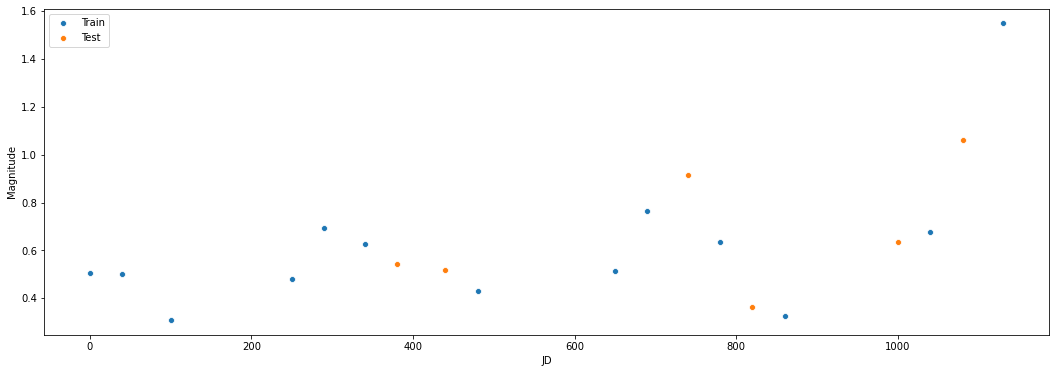

In [4]:
data = load_betelgeuse_data_random_split()

train_data, test_data = data
data = pd.concat(data, axis=0)
dates, magnitudes = data.JD, data.Magnitude
plt.figure(figsize=(18, 6))
ax = sns.scatterplot("JD", "Magnitude", data=train_data, label="Train")
sns.scatterplot("JD", "Magnitude", data=test_data, label="Test", ax=ax)

In [5]:
x_train = torch.from_numpy(train_data["JD"].values).float().unsqueeze(-1)
y_train = torch.from_numpy(train_data["Magnitude"].values).float().squeeze()

x_test = torch.from_numpy(test_data["JD"].values).float().unsqueeze(-1)
y_test = torch.from_numpy(test_data["Magnitude"].values).float().squeeze()

non_normalized_original_x_train = x_train.clone()
non_normalized_original_x_test = x_test.clone()

means = x_train.mean(dim=0, keepdim=True)[0]
stds = x_train.std(dim=0, keepdim=True)[0]

x_train = (x_train - means) / stds
x_test = (x_test - means) / stds

y_mean = y_train.mean()
y_train = y_train - y_mean
y_test = y_test - y_mean

x_vis = torch.linspace(
    min(non_normalized_original_x_test.min(), non_normalized_original_x_train.min()) - 100,
    max(non_normalized_original_x_test.max(), non_normalized_original_x_train.max()) + 100,
    steps=100,
).unsqueeze(-1)

x_vis = (x_vis - means) / stds

In [6]:
display(Code("kernels.py"))

import abc
import typing as t

import matplotlib.pyplot as plt
import torch
import math


class Kernel(abc.ABC):

    def apply(
        self,
        points: torch.Tensor,
        other_points: t.Optional[torch.Tensor] = None,
    ) -> torch.Tensor:
        """Transforms input data to obtain covariance matrix.

        Covariance matrix is used in the gaussian distribution over functions.
        :param points: Tensor of shape N x D, where N is the number of
            samples and D is the number of dimensions.
        :param other_points: Tensor of shape N' x D, where N' is the number of
            samples and D is the number of dimensions.
        :return: Matrix of size N x N'. If `other_points` is `None`, then the
            method should produce matrix N x N.
        """

        if other_points == None: other_points = points.clone()
        N = len(points)
        N_prim = len(other_points)

        covariance_matrix = torch.ones([N, N_prim])

        for i in range(len(points)):
            for j in range(len(other_points)):
                covariance_matrix[i,j] = self.eq(points[i], other_points[j])

        return covariance_matrix

    def visualize(self, num_points: int) -> plt.Axes:
        """Visualize kernel calculation.

        Example results are shown in
        https://mlss2011.comp.nus.edu.sg/uploads/Site/lect1gp.pdf.
        :param num_points: Number of points to generate.
        :return: Plot figure with kernel working
        """
        x = torch.arange(num_points).unsqueeze(-1).float()
        num_samples = x.shape[0]
        results = (
            self.apply(x)
            .reshape((num_samples, num_samples))
            .detach()
            .cpu()
            .numpy()
        )

        fig, ax = plt.subplots(1, 1)
        plt.imshow(results)

        return fig


class RBFKernel(Kernel):
    def __init__(self, variance: float, lengthscale: float):
        self.lengthscale = lengthscale
        self.variance = variance

    def eq(self, x1, x2):
        nominator = -((x1-x2)**2)
        denominator = (2*self.lengthscale**2)
        res = self.variance * math.exp(nominator/denominator)
        return res


class PeriodicKernel(Kernel):
    def __init__(
        self, lengthscale: float, periodicty: float, deviation: float
    ):
        self.lengthscale = lengthscale
        self.periodicity = periodicty
        self.deviation = deviation

    def eq(self, x1, x2):
        nominator = -(2*math.sin(math.pi*abs(x1-x2)/self.periodicity)**2)
        denominator = (self.lengthscale**2)
        res = self.deviation**2 * math.exp(nominator/denominator)
        return res


class KernelCombiner(Kernel):
    def __init__(self, *kernels: Kernel):
        self.kernels = kernels

    def apply(self,points: torch.Tensor,other_points: t.Optional[torch.Tensor] = None,) -> torch.Tensor:
        if other_points == None: other_points = points.clone()

        N = len(points)
        N_prim = len(other_points)
        cov_matrix = torch.ones([N, N_prim])

        for kernel in self.kernels:
            cov_matrix *= kernel.apply(points, other_points)
        return cov_matrix

## Kernels
The main reference for kernels, to be implemented in this task, is: _A Visual Exploration of Gaussian Processes_, Jochen Görtler, Rebecca Kehlbeck, Oliver Deussen ([link](https://distill.pub/2019/visual-exploration-gaussian-processes/)).

The first part contains implementing kernels. A kernel has a method `apply` that takes two matrices $N \times D$ (where $N$ is the number of samples and $D$ is the dimension of each sample) and outputs distance matrix $N \times N$ that is considered as a covariance matrix of the multivariate gaussian. If the second argument is `None`, that the first matrix is used as the `other_points` argument. You can also combine kernels. The combination of kernels: $\{K_1, K_2, ..., K_m\}$ is performed as:
$$
\hat{y} = \prod^M_{i=1}K_i(x^{(1)}, x^{(2)})
$$
where $x^{(1)}$ and $x^{(2)}$ are $N \times D$ matrices. 

Results of kernels can be easily visualized on dummy dataset. The visualization is already provided for you. Play with parameters of kernels to check how they influence the results.

Parameter naming in each kernel constructor is taken from [[3]](https://distill.pub/2019/visual-exploration-gaussian-processes/).

In [7]:
from gp import *
from kernels import *

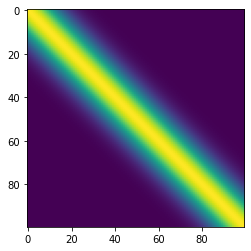

In [8]:
RBFKernel(4, 10).visualize(100)
print()

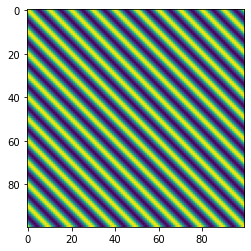

In [9]:
PeriodicKernel(4, 10, 15).visualize(100)
print()

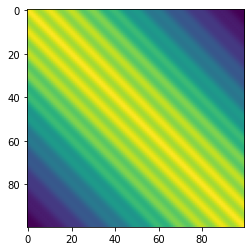

In [10]:
KernelCombiner(
    RBFKernel(1, 50),
    PeriodicKernel(4, 10, 15)
).visualize(100)
print()

# Implementing GPR
The implementation should be performed in `gp.py`.

## Few notes on numerical stability

While the dataset was thoroughly processed to avoid float problems, many of can meet with issues regarding obtaining singular matrices in estimating parameters of multivariate gaussians. To avoid this, you have to assume that datapoints are samples from a noisy distribution. Then, the formula of GP changes a bit but provides higher robustness both in terms of numerical stability and data extrapolation. More info is provided in attached readings.

To avoid numerical stabilities, you can follow the description in _Gaussian Processes for Machine Learning_, Carl Edward Rasmussen Christopher K. I. Williams ([link](http://www.gaussianprocess.org/gpml/chapters/RW.pdf))

Summarizing, there are few general tricks:
- using `jitter` matrix that changes diagonals of the covariance matrix $\Sigma$ with small values of $\epsilon$, ex. the cell below raises `RuntimeError`

In [11]:
#example_matrix = torch.randn(10, 10)
#example_matrix[0] = example_matrix[1]
#example_matrix.inverse()

while that below, does not

In [12]:
#example_matrix += torch.eye(len(example_matrix)) * 1e-6
#example_matrix.inverse()

- the other trick involves using Cholesky decomposition, ex. from p. 19 of _Gaussian Processes for Machine Learning_ by C. E. Rasmussen & C. K. I. Williams. Here, we implement two lines of their algorithm:
$$
L := \text{cholesky}(K + \sigma_n^2 I) \\
\mathbf{\alpha} := L^T\setminus(L\setminus\mathbf{y})
$$

In [13]:
K = torch.eye(100)  # example matrix 100 x 100
y = torch.randn(100, 1)  # example `y` 100 x 1
L = K.cholesky()  # cholesky decomposition
partial = y.triangular_solve(L, upper=False)[0]  # solving system of linear equations for triangular matrix
alpha = partial.triangular_solve(L, upper=False, transpose=True)[0]  # final results
print(alpha.shape)

torch.Size([100, 1])


More info about Cholesky composition can be found [on Wikipedia page](https://en.wikipedia.org/wiki/Cholesky_decomposition) (surprisingly, it is described quite intuitively).

Trivia: `torch.distributions.MultivariateDistribution` uses the Cholesky decomposition on the variance matrix under the hood.

## Final notes on the implementation

In this task, you have to implement the following methods:
- `fit_train` method that calculates base parameters of a multivariate gaussians and saves them for future inferences. The method takes $N \times D$ matrix 
- `forward` method that takes test dataset, calculates new covariance matrix basing on these points and training points, and provides a multivariate distribution over functions for these points
- `sample_fun` that produces a single instance of function crossing training points - many samplings should provide approximate confidence intervals
- `log_likelihood` that calculates likelihood of fitted model to the training data - this should be used to find the best parameters of kernels
- `confidence_interval` that returns $N \times 2$ matrix of .95 confidence interval values  where the first column is an upper bound of the interval, and the second - the lower bound

In [14]:
display(Code("gp.py"))

from __future__ import annotations

import abc
import typing as t

import matplotlib.pyplot as plt
import torch
import torch.distributions as dist
import numpy as np
import scipy.stats as st
from kernels import Kernel


class Regressor(abc.ABC):
    @abc.abstractmethod
    def fit_train(self, x: torch.Tensor, y: torch.Tensor) -> Regressor:
        """Fit to the training data.

        :param x: N x D matrix of the input data points.
        :param y: N x K matrix of targets for K predicted values.
        :return: self
        """

    @abc.abstractmethod
    def forward(self, x: torch.Tensor) -> t.Any:
        """Predict value for each point in the input data.

        It also should save parameters of the multivariate distribution for
        given points so it can be used `sample_fun` method.

        :param x: N x D matrix of the input data points.
        :return: Anything that you need.
        """

    @abc.abstractmethod
    def confidence_interval(self, x: torch.Tensor) -> torch.Tensor:
        """For each sampling point return its upper and lower confidences.

        It should be realised .95 confidence interval.
        :param x: Input data points of N' x D dimensions.
        :return: Confidence intervals of N' x 2 (lower and upper bounds).
        """

    @abc.abstractmethod
    def log_likelihood(self) -> t.Union[float, torch.Tensor]:
        """Calculate log probability of the fitted model.

        :return: scalar with the log likelihood value.
        """

    @abc.abstractmethod
    def sample_fun(self):
        """Samples single function using test data.

        Test data should be used in `forward` method before calling this
        method.
        :return: M x 1 function values where M is number of data points used
            in the `forward` method.
        """


class GPRegressor(Regressor):
    def __init__(self, kernel: Kernel, noise: float, jitter: float):
        self.kernel = kernel
        self.noise = noise
        self.jitter = jitter # eng. (drÅ¼enie) do robienia szumu gdy nie da sie inverse matrix zrobiÄ‡
                             # inverse_cpu: U(10,10) is zero, singular U. itp

    def fit_train(self, x: torch.Tensor, y: torch.Tensor) -> Regressor:
        noise_matrix = torch.eye(len(x)) * self.noise
        self.cov_matrix = self.kernel.apply(x) + noise_matrix #covariance matrix + noice
        self.x = x
        self.y = y

    def forward(self, x: torch.Tensor) -> t.Any: # Predict value for each point in the input data.
        self.ker_1_t = self.kernel.apply(self.x, x).t()
        self.ker_2 = self.kernel.apply(x)
        self.mi = torch.mm(self.ker_1_t.t(), self.cov_matrix.inverse())
        self.mi = self.mi @ self.y
        self.sigma = self.ker_2 - (self.ker_1_t.t() @ self.cov_matrix.inverse() @ self.ker_1_t)

    def confidence_interval(self, x: torch.Tensor) -> torch.Tensor: # For each sampling point return its upper and lower confidences.
        self.forward(x)
        samples_number = 100
        N = len(x)
        samples = torch.ones(samples_number, N)
        res = torch.ones(N, 2)

        for i in range(samples_number):
            samples[i] = self.sample_fun()
        for i in range(N):
            c = st.norm.interval(0.95, loc=samples[:,i].mean(), scale=samples[:,i].var())
            res[i,0] = c[0]
            res[i,1] = c[1]
        return res #Confidence intervals of N' x 2 (lower and upper bounds).

    def log_likelihood(self) -> t.Union[float, torch.Tensor]:
        mu = self.y
        sigma = self.cov_matrix
        res = dist.MultivariateNormal(mu, sigma).log_prob(self.y)
        return res #scalar with the log likelihood value.

    def sample_fun(self):
        #example_matrix += torch.eye(len(example_matrix)) * 1e-6
        noice = torch.eye(self.sigma.size()[0])*self.jitter
        sigma = self.sigma + 2*noice
        return dist.MultivariateNormal(self.mi, sigma).sample(torch.tensor([1])).squeeze()



def visualize_data_and_intervals(
    x_train: 

#### Using RBF kernel

In [15]:
gp_regressor = GPRegressor(
    RBFKernel(1, 0.1), 2e-6, jitter=1e-4
)
gp_regressor.fit_train(x_train, y_train)

print(f"Log prob of the model: {gp_regressor.log_likelihood().item()}")

visualize_data_and_intervals(
    x_train, y_train,
    x_test, y_test,
    x_vis,
    gp_regressor
)
plt.show()


Log prob of the model: -11.16761589050293


RuntimeError: size mismatch, m1: [13 x 100], m2: [13 x 13] at C:\w\1\s\windows\pytorch\aten\src\TH/generic/THTensorMath.cpp:136

In [ ]:
visualize_data_samplings(
    x_train, y_train,
    x_test, y_test,
    x_vis,
    gp_regressor,
    num_iterations=5
)

#### Using periodic kernel

In [ ]:
gp_regressor = GPRegressor(
    PeriodicKernel(1.1, 0.5, 1.5), 1e-4, jitter=7e-2
)
gp_regressor.fit_train(x_train, y_train)

print(f"Log prob of the model: {gp_regressor.log_likelihood().item()}")

visualize_data_and_intervals(
    x_train, y_train,
    x_test, y_test,
    x_vis,
    gp_regressor
)
plt.show()

In [ ]:
visualize_data_samplings(
    x_train, y_train,
    x_test, y_test,
    x_vis,
    gp_regressor,
    num_iterations=5
)

#### Using combined kernel

In [ ]:
gp_regressor = GPRegressor(
    KernelCombiner(
        RBFKernel(0.01, 0.2),
        PeriodicKernel(2.1, 0.5, 1.5)
    ), 1e-4, jitter=5e-2
)
gp_regressor.fit_train(x_train, y_train)

print(f"Log prob of the model: {gp_regressor.log_likelihood().item()}")

visualize_data_and_intervals(
    x_train, y_train,
    x_test, y_test,
    x_vis,
    gp_regressor
)
plt.show()

In [ ]:
visualize_data_samplings(
    x_train, y_train,
    x_test, y_test,
    x_vis,
    gp_regressor,
    num_iterations=5
)

In [ ]:
x = torch.rand(2,2)

In [ ]:
x

In [ ]:
x[1,1]

In [ ]:
torch.tensor(3-2)

In [ ]:
torch.norm(torch.tensor(99.-33.))